# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

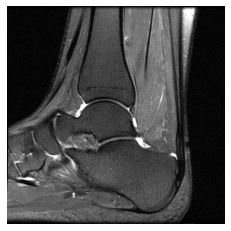

In [25]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os
from scipy import signal
import cv2
import copy

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

#TODO Samodzielna
mat = loadmat('MR_data.mat')

Input_1 = mat['I_noisy1']
Input_2 = mat['I_noisy2']
Input_3 = mat['I_noisy3']
Input_4 = mat['I_noisy4']
Input_0 = mat['I_noisefree']

plt.imshow(Input_4, 'gray')
plt.axis('off')
plt.show()

In [3]:
def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g /g.sum() 

In [4]:
def fgaussian_bez(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g 

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

In [5]:
Input_1_gaus=signal.convolve2d(Input_1,fgaussian(5,0.7),mode='same')

In [6]:
def pixel_out(okno,filtr,variancy):
    A,B = okno.shape
    pixel=0
    x = [A//2,B//2]
    for i in range(A):
        for j in range(B):
            AB=[i,j]
            
            y=np.sqrt(((x[0]-AB[0])**2)+((x[1]-AB[1])**2))
            gaus= np.exp(-(y**2)/(2*(variancy**2)))
            pixel=pixel+gaus*okno[i,j]
    pixel=pixel/filtr.sum()
    return pixel

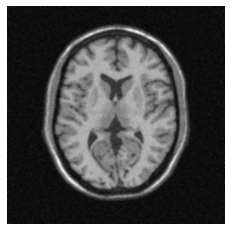

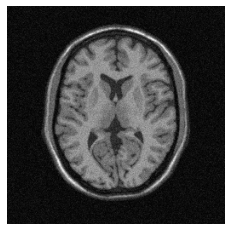

In [7]:
#TODO Samodzielna
def convol(img,window,variancy):
    filtr=fgaussian_bez(5,variancy)
    IConv = img.copy()
    (X,Y)=IConv.shape
    polowa = window//2
    for i in range(0+window//2,X-window//2):
        for j in range(0+window//2,Y-window//2):
            okno = IConv[i-polowa:i+polowa+1,j-polowa:j+polowa+1]
            new_pixel=pixel_out(okno,filtr,variancy)
            IConv[i,j]=new_pixel
    return IConv
        
img_after=convol(Input_1,5,0.7)
plt.imshow(img_after, 'gray')
plt.axis('off')
plt.show()
plt.imshow(Input_1, 'gray')
plt.axis('off')
plt.show()


### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [8]:
def pixel_out_2(okno,filtr,variancy,delta_r):
    A,B = okno.shape
    pixel=0
    normalization=0
    x = [A//2,B//2]
    for i in range(A):
        for j in range(B):
            AB=[i,j]
            
            y=np.sqrt(((x[0]-AB[0])**2)+((x[1]-AB[1])**2))
            gaus= np.exp(-(y**2)/(2*(variancy**2)))
            
            diff=np.abs(okno[A//2,B//2]-okno[i,j])
            gaus_diff= np.exp(-(diff**2)/(2*(delta_r**2)))
            
            
            pixel=pixel+gaus*gaus_diff*okno[i,j]
            normalization+=gaus*gaus_diff
    pixel=pixel/(normalization)
    return pixel

In [27]:
#TODO Samodzielna
def bilateral(img,window,variancy,delta_r):
    filtr=fgaussian_bez(window,variancy)
    IConvolucja = img.copy()
    (X,Y)=IConvolucja.shape
    polowa = window//2
    for i in range(0+window//2,X-window//2):
        for j in range(0+window//2,Y-window//2):
            okno = IConvolucja[i-polowa:i+polowa+1,j-polowa:j+polowa+1]
            new_pixel=pixel_out_2(okno,filtr,variancy,delta_r)
            IConvolucja[i,j]=new_pixel
    return IConvolucja




(-0.5, 255.5, 255.5, -0.5)

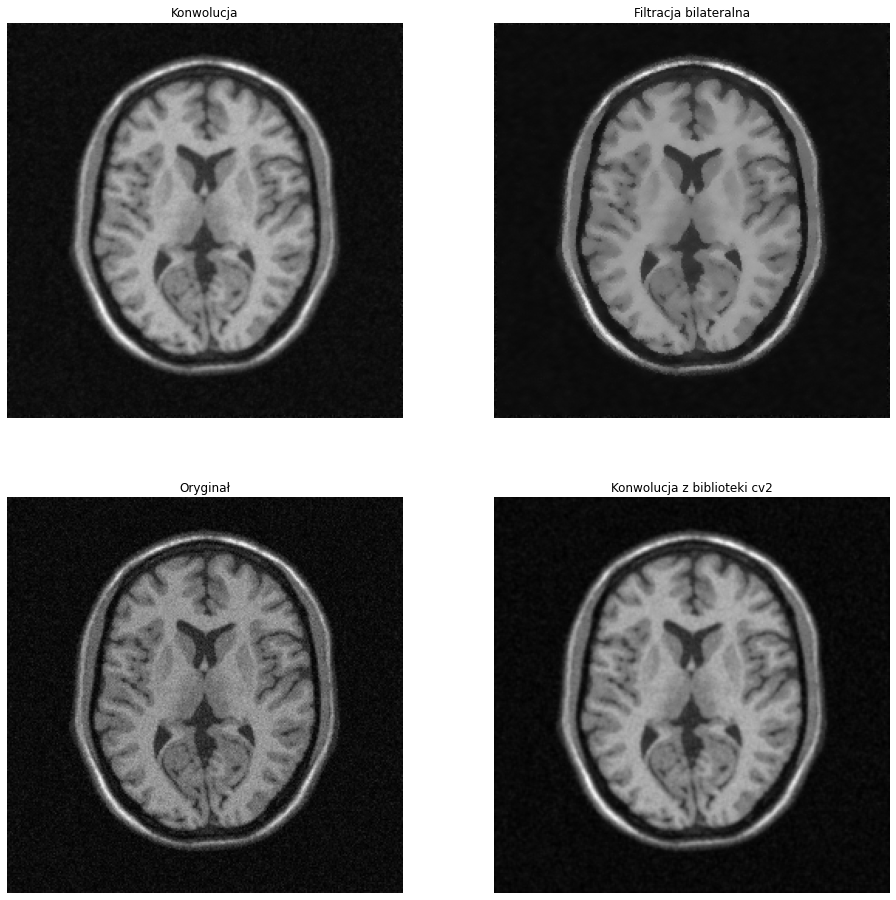

In [29]:
window=5
variancy=0.7
delta_r=20
variancy_1=5
convolucja=convol(Input_1,window,variancy)
bilateralne=bilateral(Input_1,window,variancy_1,delta_r)
Input_1_gaus=signal.convolve2d(Input_1,fgaussian(5,0.7),mode='same')

f, ax1 = plt.subplots(2,2,figsize=(16,16))
ax1[0,0].imshow(convolucja, 'gray')
ax1[0,0].set_title("Konwolucja")
ax1[0,0].axis('off')
ax1[0,1].imshow(bilateralne, 'gray')
ax1[0,1].set_title("Filtracja bilateralna")
ax1[0,1].axis('off')
ax1[1,0].imshow(Input_1, 'gray')
ax1[1,0].set_title("Oryginał")
ax1[1,0].axis('off')
ax1[1,1].imshow(Input_1_gaus, 'gray')
ax1[1,1].set_title("Konwolucja z biblioteki cv2")
ax1[1,1].axis('off')

(-0.5, 255.5, 255.5, -0.5)

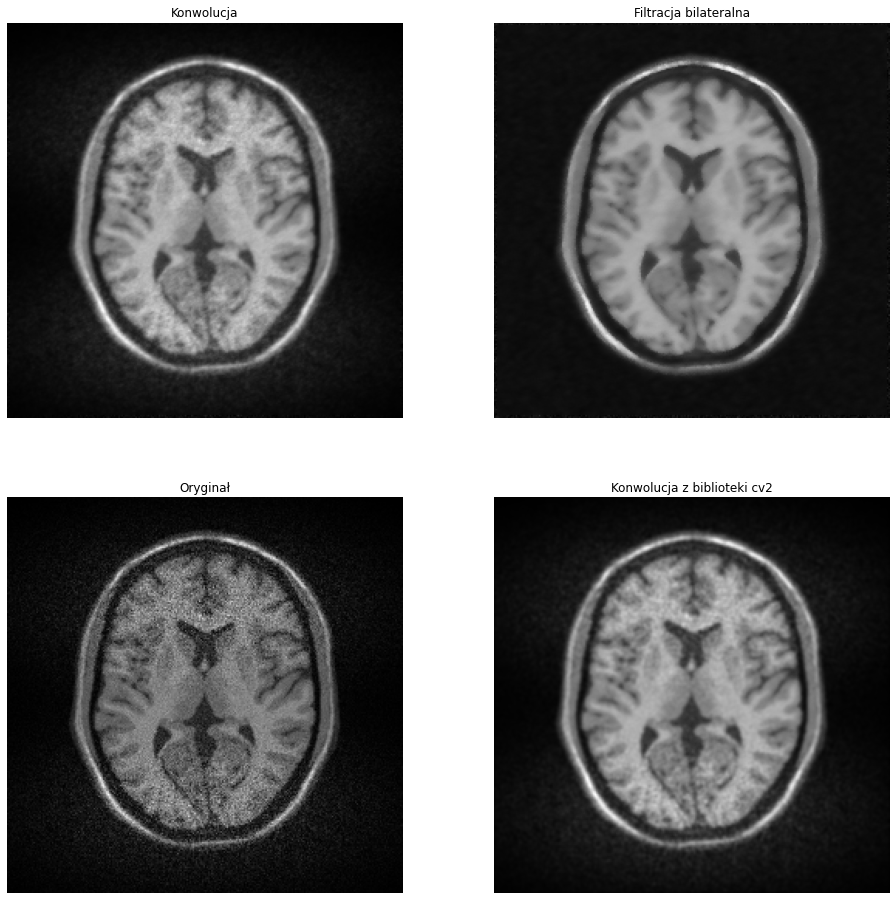

In [30]:
window=5
variancy=0.9

delta_r=45
variancy_1=3
convolucja_2=convol(Input_2,window,variancy)
#bilateralne_2=bilateral(Input_2,window,variancy_1,delta_r)
Input_2_gaus=signal.convolve2d(Input_2,fgaussian(5,variancy),mode='same')

f, ax1 = plt.subplots(2,2,figsize=(16,16))
ax1[0,0].imshow(convolucja_2, 'gray')
ax1[0,0].set_title("Konwolucja")
ax1[0,0].axis('off')
ax1[0,1].imshow(bilateralne_2, 'gray')
ax1[0,1].set_title("Filtracja bilateralna")
ax1[0,1].axis('off')
ax1[1,0].imshow(Input_2, 'gray')
ax1[1,0].set_title("Oryginał")
ax1[1,0].axis('off')
ax1[1,1].imshow(Input_2_gaus, 'gray')
ax1[1,1].set_title("Konwolucja z biblioteki cv2")
ax1[1,1].axis('off')

<ipython-input-8-af2e95cb390c>:13: RuntimeWarning: overflow encountered in ubyte_scalars
  diff=np.abs(okno[A//2,B//2]-okno[i,j])


(-0.5, 559.5, 559.5, -0.5)

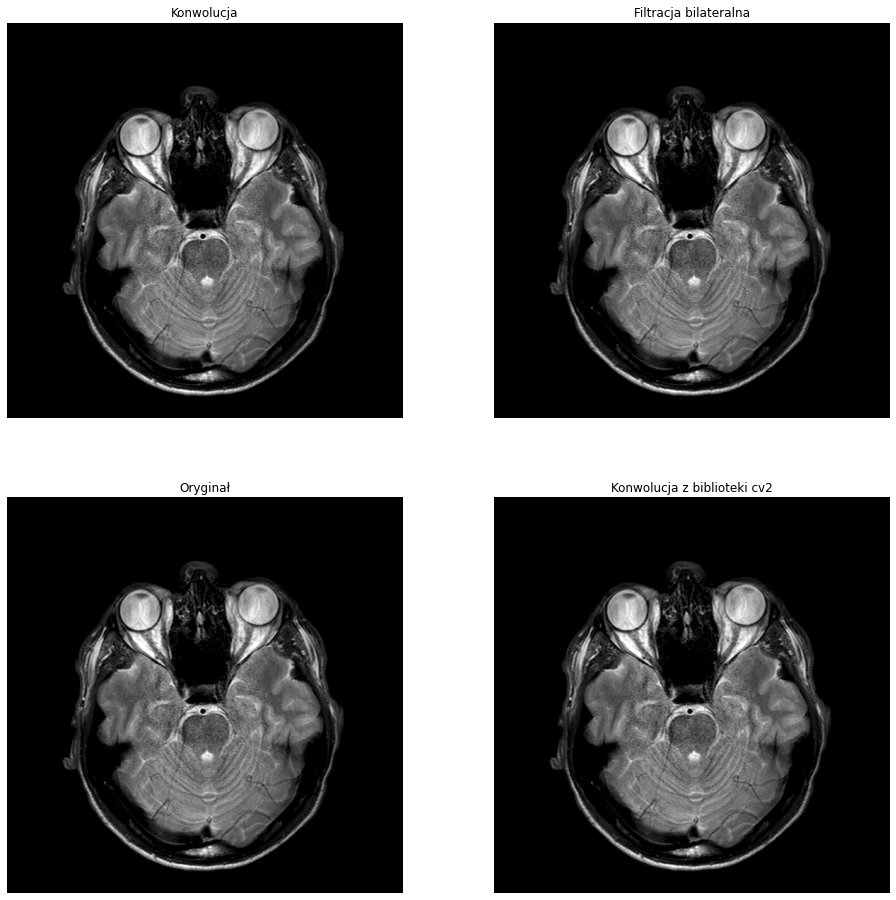

In [31]:
window=5
variancy=0.1

delta_r=5
variancy_1=0.5
convolucja_3=convol(Input_3,window,variancy)
bilateralne_3=bilateral(Input_3,window,variancy_1,delta_r)
Input_3_gaus=signal.convolve2d(Input_3,fgaussian(5,variancy),mode='same')

f, ax1 = plt.subplots(2,2,figsize=(16,16))
ax1[0,0].imshow(convolucja_3, 'gray')
ax1[0,0].set_title("Konwolucja")
ax1[0,0].axis('off')
ax1[0,1].imshow(bilateralne_3, 'gray')
ax1[0,1].set_title("Filtracja bilateralna")
ax1[0,1].axis('off')
ax1[1,0].imshow(Input_3, 'gray')
ax1[1,0].set_title("Oryginał")
ax1[1,0].axis('off')
ax1[1,1].imshow(Input_3_gaus, 'gray')
ax1[1,1].set_title("Konwolucja z biblioteki cv2")
ax1[1,1].axis('off')

<ipython-input-8-af2e95cb390c>:13: RuntimeWarning: overflow encountered in ubyte_scalars
  diff=np.abs(okno[A//2,B//2]-okno[i,j])


(-0.5, 511.5, 511.5, -0.5)

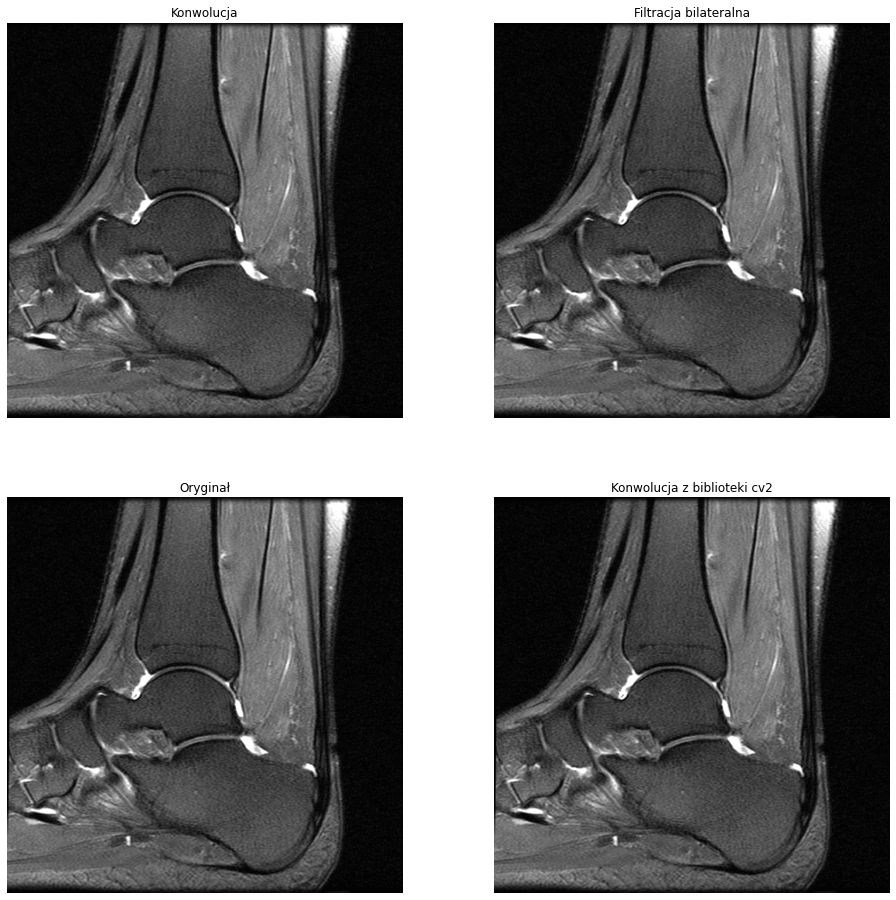

In [32]:
window=5
variancy=0.1

delta_r=5
variancy_1=0.5
convolucja_4=convol(Input_4,window,variancy)
bilateralne_4=bilateral(Input_4,window,variancy_1,delta_r)
Input_4_gaus=signal.convolve2d(Input_4,fgaussian(5,variancy),mode='same')

f, ax1 = plt.subplots(2,2,figsize=(16,16))
ax1[0,0].imshow(convolucja_4, 'gray')
ax1[0,0].set_title("Konwolucja")
ax1[0,0].axis('off')
ax1[0,1].imshow(bilateralne_4, 'gray')
ax1[0,1].set_title("Filtracja bilateralna")
ax1[0,1].axis('off')
ax1[1,0].imshow(Input_4, 'gray')
ax1[1,0].set_title("Oryginał")
ax1[1,0].axis('off')
ax1[1,1].imshow(Input_4_gaus, 'gray')
ax1[1,1].set_title("Konwolucja z biblioteki cv2")
ax1[1,1].axis('off')